### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! All four have been imported for you in this Notebook.**

In [324]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data loading

Train and Test sets can be found in the `Resources` folder. You can choose to visualize your data all at once, in windows, or only considering a subset of sensors to detect which ones would prove most useful to your analysis.
An example of such a visualization can be found in the following cell.

In [325]:
train_file_path = 'lab1_train.csv'

train_data = pd.read_csv(train_file_path, delimiter=',', skipinitialspace= True)

# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

test_file_path = 'lab1_test.csv'

test_data = pd.read_csv(test_file_path, delimiter=',', skipinitialspace= True)

# Convert Timestamp column to datetime
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

In [326]:
def visualize_sensor_data(df, window=None, sensors=None):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    plt.legend()

    plt.show()

# Familiarization 
### What types of signals are there?
All of them seem to be semi-continuous and clearly not random, which is to be expected with time series, as previous signals will likely not vary much from one point to another. This can be seen when analysing the signals with a very small window. There are also some signals which seem to be more "constant", one of them exhibiting one rather discrete "jump".

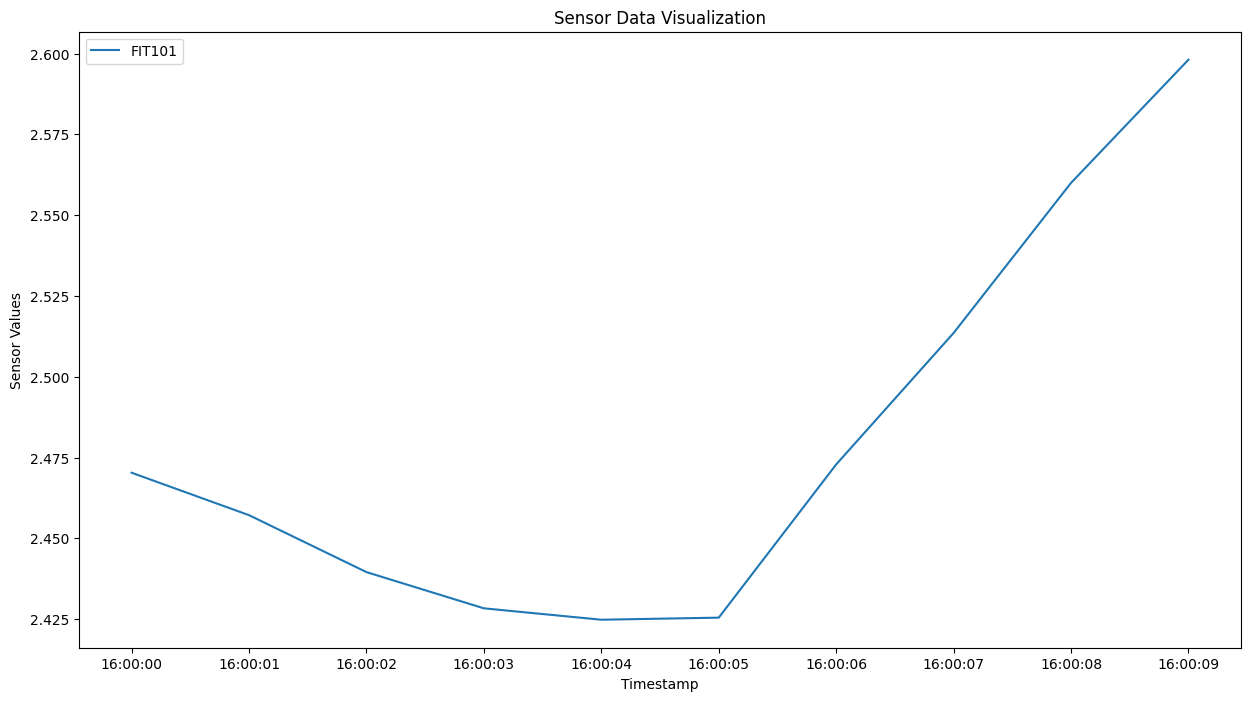

In [327]:
visualize_sensor_data(train_data, window=(0, 10), sensors=['FIT101'])

There are also some signals which seem to be more "constant", one of them also exhibiting one rather discrete "jump".

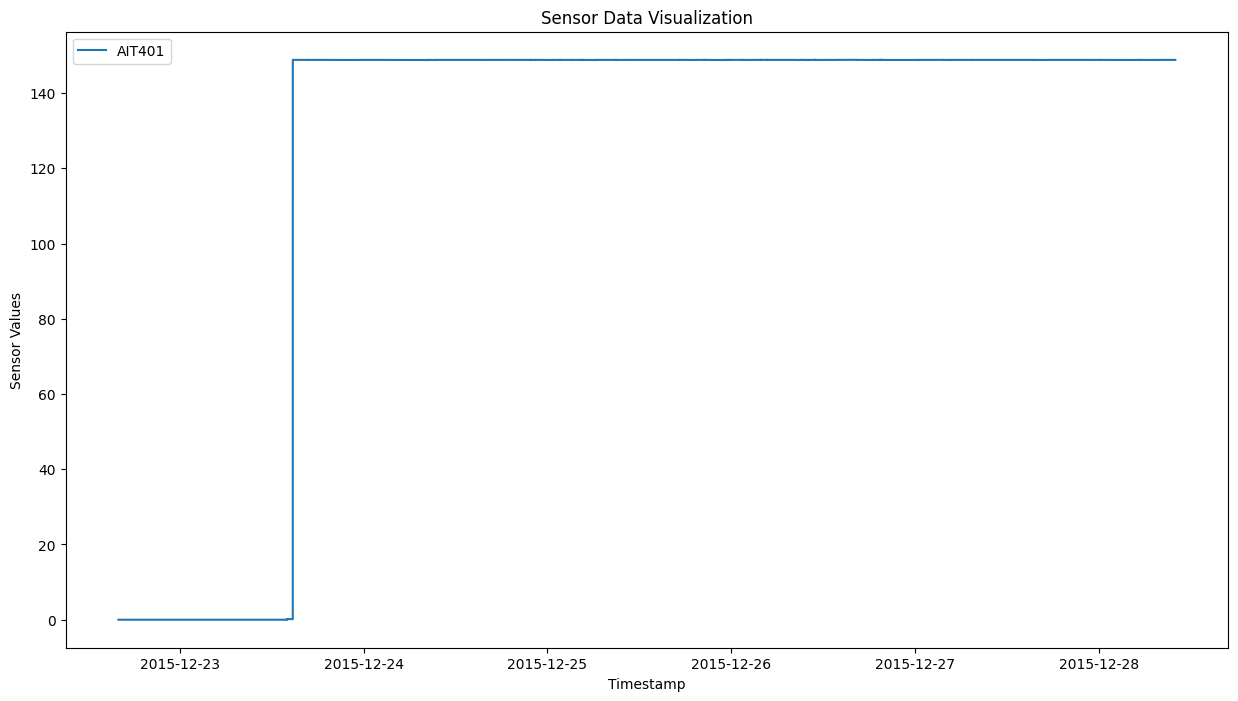

In [328]:
visualize_sensor_data(train_data, sensors=['AIT401'])

### Are the signals correlated? Do they show cyclic behavior?
Some of the signals can be seen as correlated, showing, for example, some unusual behaviour - compared to the rest, both around the (temporal) beginning of the dataset (which can be associated with the system booting up, and also at a point in time between 2015-12-23 and 2015-12-24. Moreover, cyclic behaviour is clearly shown for almost all the signals.

In [329]:
# visualize_sensor_data(train_data) # takes a bit to run, you can un-comment the line to test it

# DTW-based anomaly detection
We will be focusing on signal `LIT101`:

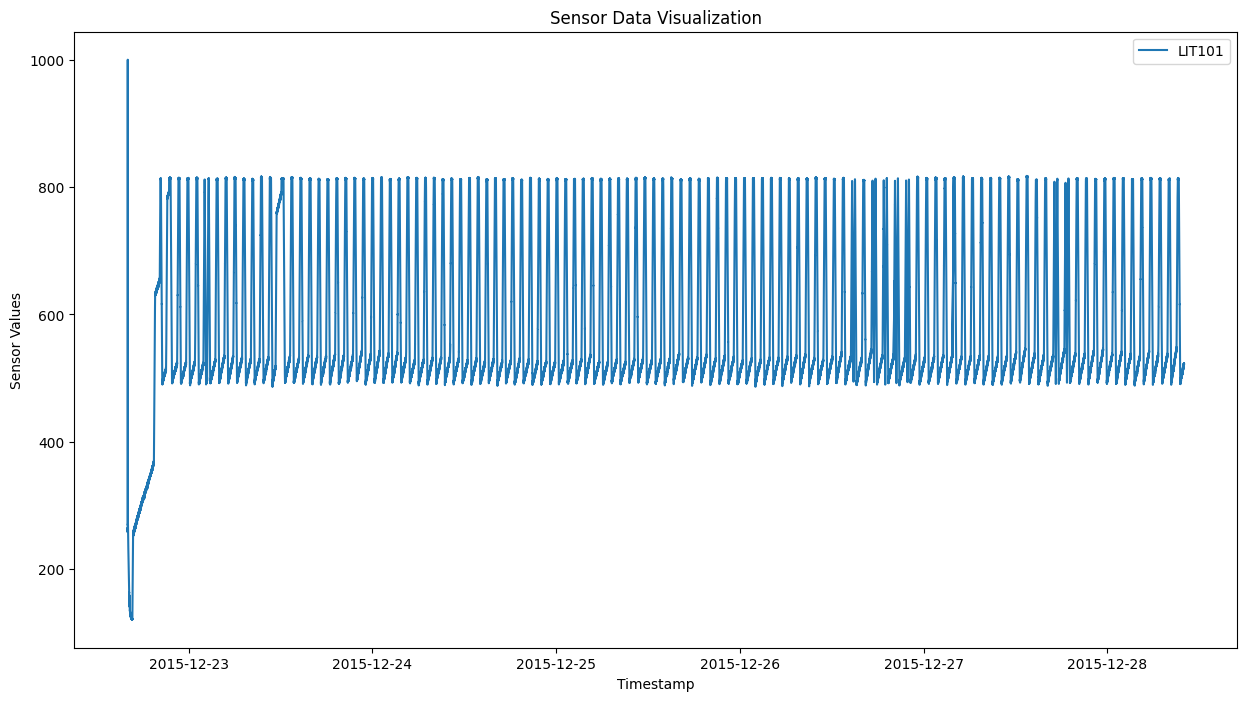

In [330]:
visualize_sensor_data(train_data, sensors=['LIT101'])

Since we will consider the first part of the timeseries as a period for booting up the sequence, we will exclude it from our training data (by finding the index of the row at which the "boot" sequence has ended ~ through experiment found around 17000):

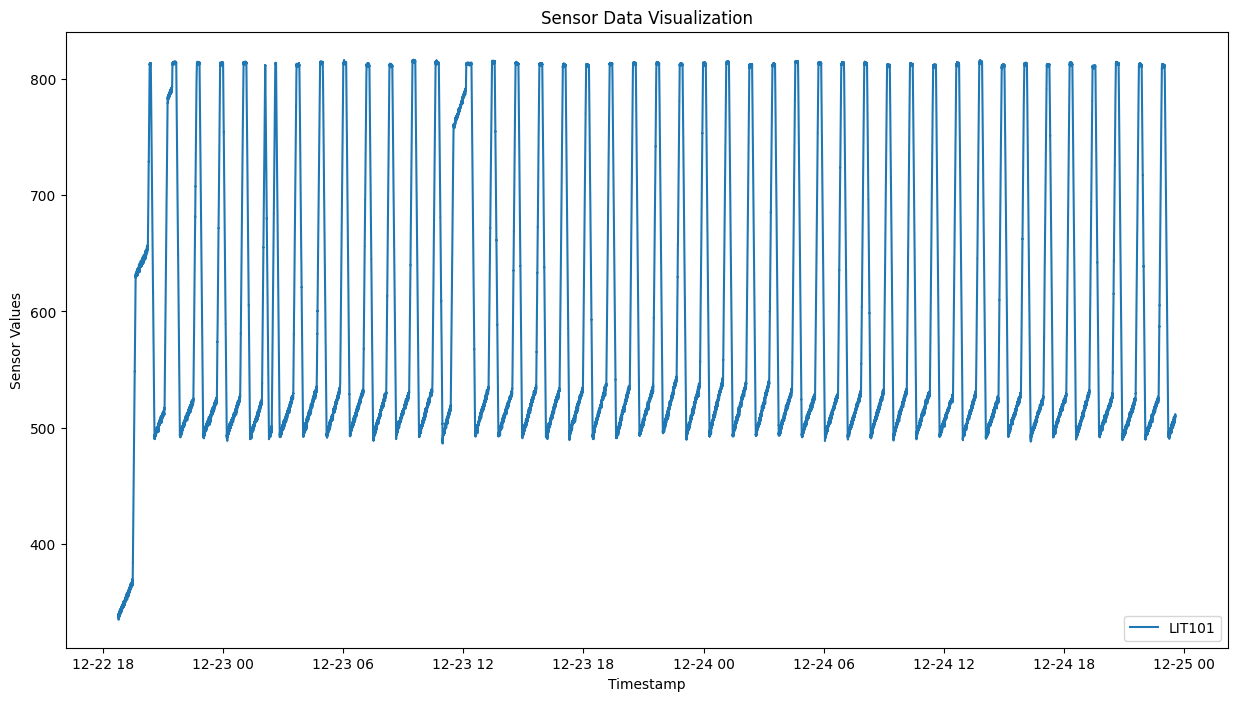

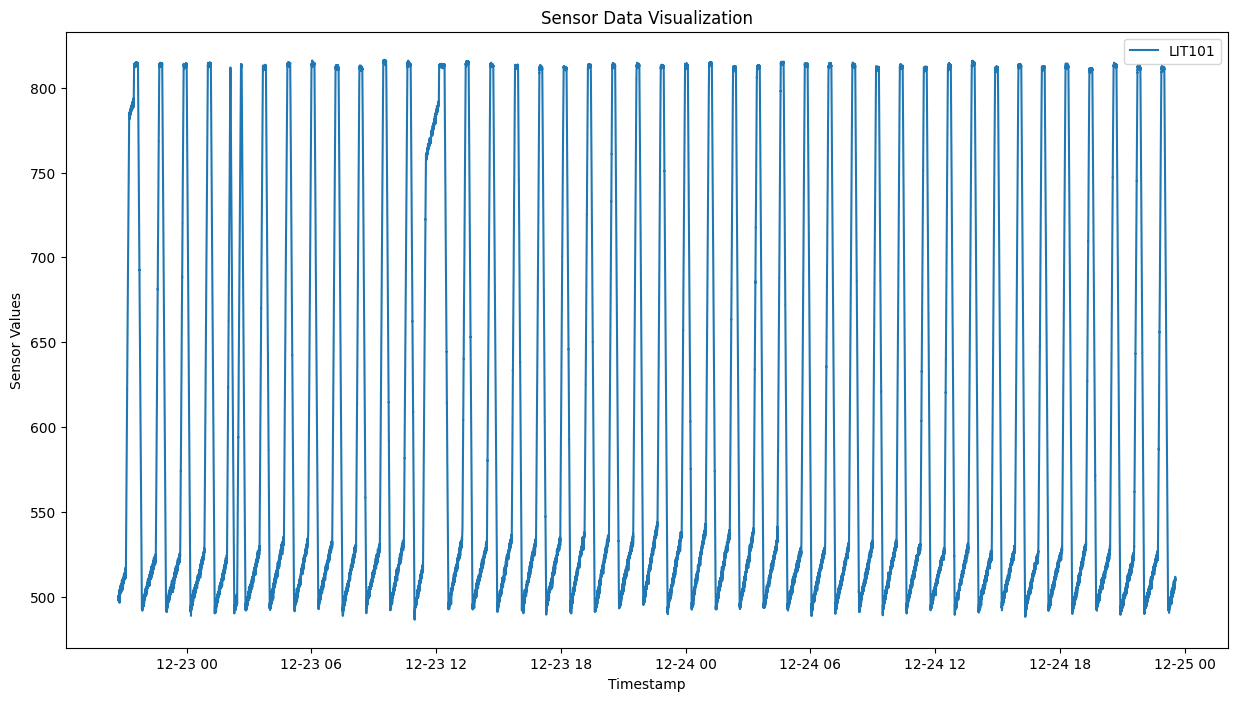

In [331]:
visualize_sensor_data(train_data, sensors=['LIT101'], window=(10000,200000))
visualize_sensor_data(train_data, sensors=['LIT101'], window=(17000,200000))

One could also exclude the first part of the test dataset as well based on a similar reasoning, however we will not as the timestamp intervals of the test and training set do not overlap, thus we can't "excuse" any abnormal behaviour in the beginning of the test set.

In [332]:
sensor_name = 'LIT101'
trimmed_train_data = train_data[17000:][['Timestamp',sensor_name]]
# trimmed_test_data = test_data[17000:][['Timestamp',sensor_name]]
trimmed_test_data = test_data[['Timestamp',sensor_name]]

First we define the general dtw algorithm that we will be using (based on the implementation from Weblab). This is standard DTW, not Fast DTW, as we have seen that the latter doesn't provide much of a speedup, at least for our settings.

In [333]:
def dynamic_time_warping(a, b):
    n = a.size
    m = b.size
    matrix = np.zeros((n+1,m+1)) # we are filling the matrix with actual distance variables from 1 to n, respectively from 1 to m
    for i in range(n):
        for j in range(m):
            matrix[i+1,j+1]=(a[i]-b[j])**2
    for i in range(0,m+1):
        matrix[0,i]=1000000000
    for i in range(1,n+1):
        matrix[i,0]=1000000000
    for i in range(1,n+1):
        for j in range( 1,m+1):
            if i+j!=2:
                matrix[i,j]=matrix[i,j]+min(matrix[i-1,j],matrix[i-1,j-1],matrix[i,j-1])
    return matrix[n,m]**0.5

The general approach of the algorithm first defines the parameters that are going to be used. The representative windows will be randomly chosen from our train set (where all points are labeled as Normal). Even though there might still be anomalous points / windows in the training dataset, there is a very low possibility that those will actually be included in our representative window since they are chosen randomly out of all possible windows. However, suffering from the curse of dimensionality, a high number of representative windows increases the chances of erroneous windows to be included in the representative set.

The window size is chosen such that approximately two "standard" bumps are included, and the jump size ensures that there is some overlap between windows, in order to account for synchronization issues between test and train data.

In [334]:
window_size = 6000
jump_size = 3000
number_of_representative_windows = 20
sub_sampling_size = 100

#generating all possible windows of our chosen size and randomly choosing 20 windows as our representative windows
data_windows = np.lib.stride_tricks.sliding_window_view(trimmed_train_data[sensor_name],(window_size,))
total_windows = data_windows.shape[0]
representative_windows_indices = np.random.choice(data_windows.shape[0], size=number_of_representative_windows, replace=False)
representative_windows = data_windows[representative_windows_indices]

We will first compute the residuals for the train data. Note that the `sub_sampling_size` dramatically reduces run time, and the idea behind it is that points do not differ drastically on small intervals, thus it we still maintain accuracy if we just take points 100 apart.

In [335]:
train_distances = []
for window in data_windows[::jump_size]:
    minDist = 1e9
    for representative_window in representative_windows:
        dist = dynamic_time_warping(window[::sub_sampling_size], representative_window[::sub_sampling_size])
        if dist < minDist and dist != 0:
            minDist = dist
            
    train_distances.append(minDist)

Let's plot them, along with some statistics:

Average: 80.69917530526858
Standard deviation: 85.75439525258527


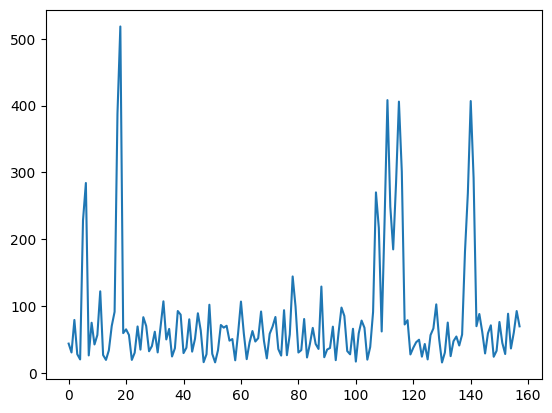

In [336]:
plt.plot(train_distances)
train_average = np.mean(train_distances)
train_std = np.std(train_distances)
print(f"Average: {train_average}")
print(f"Standard deviation: {train_std}")

In order to really avoid false alarms, we will set the threshold to `k * train_std + train_average`, where k is a parameter that could be tuned. The higher the k, the smaller the chance of a false alarm. The threshold can be observed as a red dotted line in the figure below.

Using DTW in this manner we expect to be more efficient at finding collective anomalies. We can clearly see how this reflects in our findings. The absence of cyclic signals for the continuous interval signals right after 31/12/2015 is clearly detected. Thus, a collective anomaly is detected in that interval. In this context, some contextual anomalies are also detected.

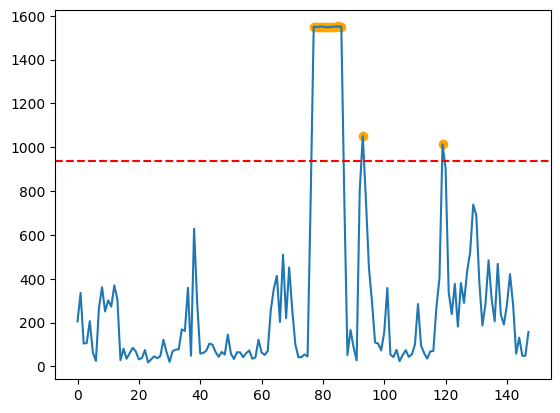

In [337]:
threshold = 10 * train_std + train_average

data_windows = np.lib.stride_tricks.sliding_window_view(trimmed_test_data[sensor_name],(window_size,))
test_distances = []
for window in data_windows[::jump_size]:
    minDist = 1e9
    for representative_window in representative_windows:
        dist = dynamic_time_warping(window[::sub_sampling_size], representative_window[::sub_sampling_size])
        if dist < minDist and dist != 0:
            minDist = dist
    test_distances.append(minDist)

plt.plot(test_distances)
above_threshold_indices = np.where(np.array(test_distances) > threshold)[0]
plt.scatter(above_threshold_indices, np.array(test_distances)[above_threshold_indices], color='orange', label='Above Threshold')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

To summarize our findings, we will also check the actual sensor data:

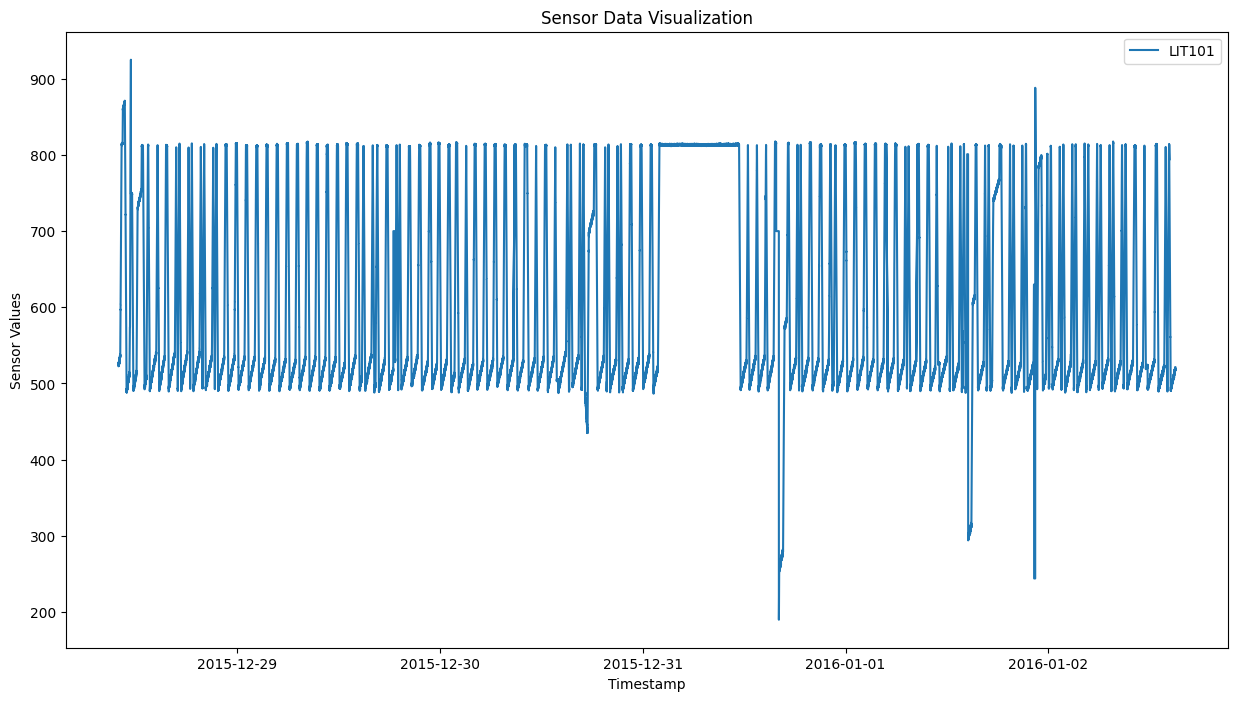

In [338]:
visualize_sensor_data(trimmed_test_data, sensors=['LIT101'])

# PCA-based anomaly detection

Focusing on the same sensor, we will first design the PCA algorithm(based on the implementation on Weblab).

In [339]:
def principal_component_analysis(df, k):
    cov_mat = df.cov()
    eigenvalues, eigenvectors = np.linalg.eigh(cov_mat) # each eigenvector is a column
    eigenvectors = eigenvectors.T # each eigenvector is a row
    sorted_eigenvectors = [x for _,x in sorted(zip(eigenvalues,eigenvectors), key=lambda pair: pair[0])]
    sorted_eigenvectors = sorted_eigenvectors[::-1]
    sorted_eigenvectors = sorted_eigenvectors[:k] # now we have list of the k-th most important eigenvectors
    sorted_matrix = np.stack( sorted_eigenvectors, axis=1) 
    return sorted_matrix
    

def apply_principal_component_analysis(df, eigenvectors):
    projected_data = np.zeros(shape=(df.shape[0], eigenvectors.shape[1]))
    projected_data = ( df - df.mean() ) @ eigenvectors #normalization
    return pd.DataFrame(projected_data)

When choosing the number of components, we first decided to try using every sensor for a higher accuracy. We implemented a function that would plot the results when using different numbers of components below. The function also reconstructs the matrix and returns an array of residuals that will be used later to identify the anomalies.

In [340]:
number_of_sensors = test_data.shape[1] - 2 # 51

def plot_res(k):
    #Preprocessing the data by removing the header row, then following the reconstruction algorithm from the slides
    only_sensor_train_data = test_data.drop(['Timestamp','Normal/Attack'], axis=1)
    mean = only_sensor_train_data.mean()
    pca_eigenvectors = principal_component_analysis(only_sensor_train_data, number_of_sensors - k)
    new_df = apply_principal_component_analysis(only_sensor_train_data, pca_eigenvectors)
    reconstructed_X = new_df @ (pca_eigenvectors.T)
    reconstructed_with_mean = pd.DataFrame(data=reconstructed_X.values + mean.values, columns=only_sensor_train_data.columns)
    diff = reconstructed_with_mean - only_sensor_train_data
    #array of residuals, comparing initial dataframe to the reconstructed one after applying PCA
    residuals = np.linalg.norm(diff, axis=1)
    #plotting an example threshold
    t=57e-14
    plt.axhline(y=t, color='r', linestyle='--', label='Threshold')
    plt.plot(residuals)
    plt.show()
    return residuals


Below we plotted the figures for 10 different numbers components used, to demonstrate our choice of using every sensor. As you can observe from the ten figures, the less components, the less clear and accurate the anomalies can be seen. 

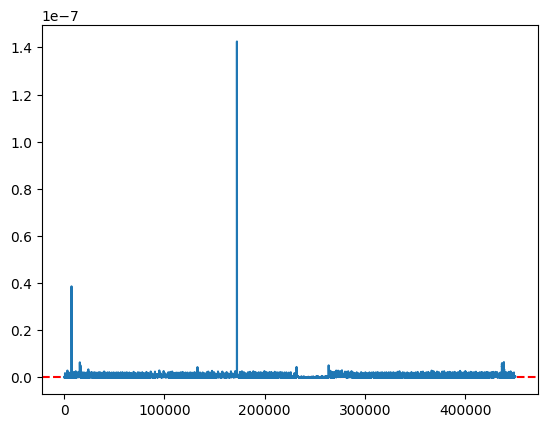

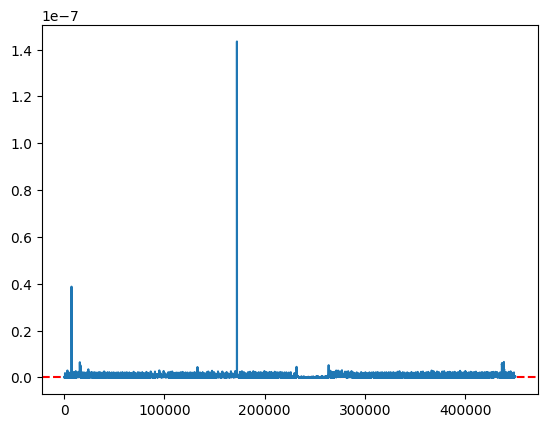

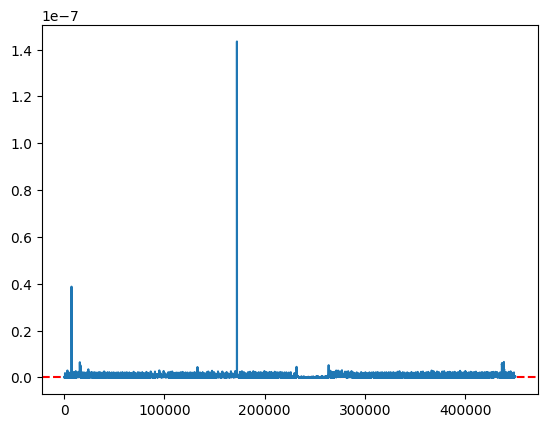

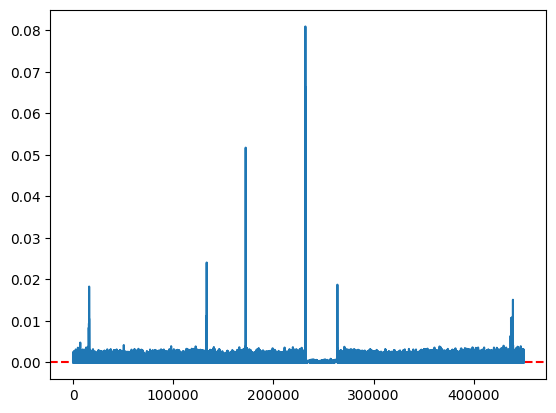

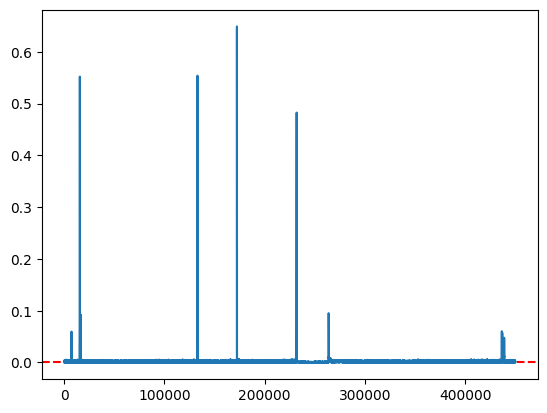

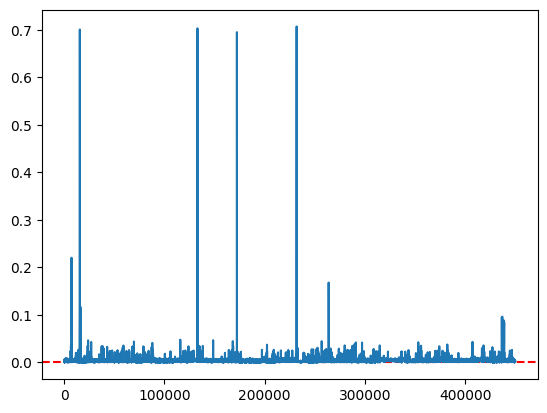

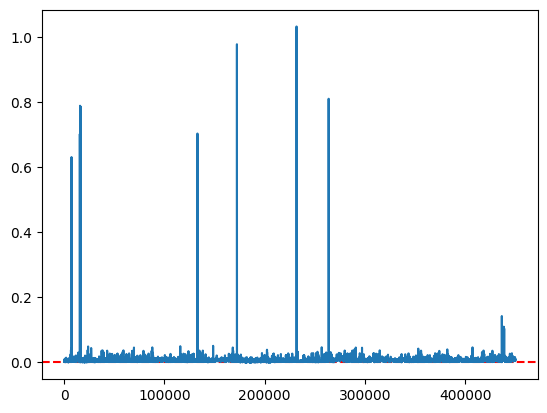

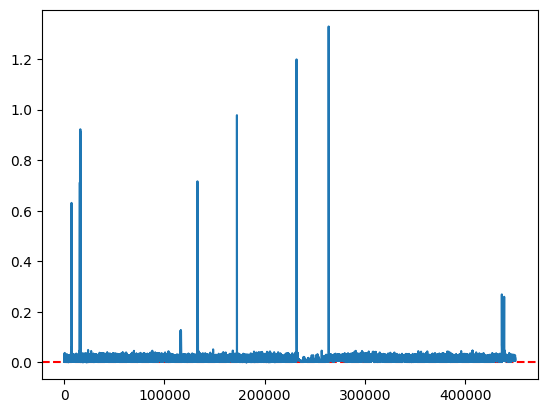

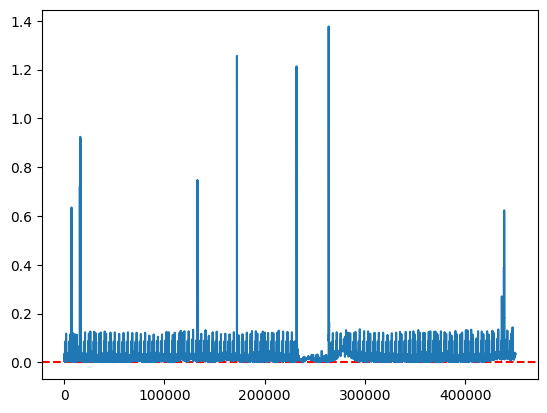

In [341]:
#Plots the residuals given 51-2*i components
for i in range(1, 10):
    plot_res(2*i)

Using every component(all 51 sensors), we can see that a threshold can be reasonably set through an eye-test.

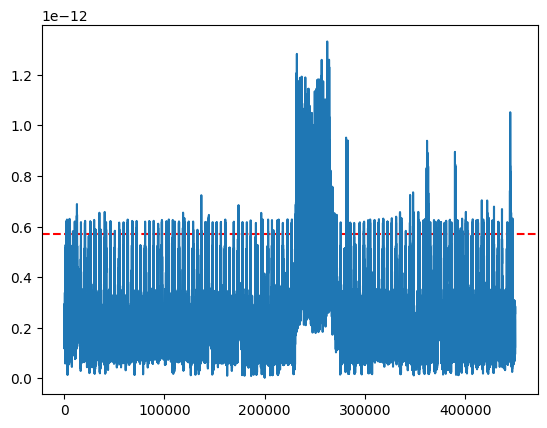

In [342]:
residuals = plot_res(0)

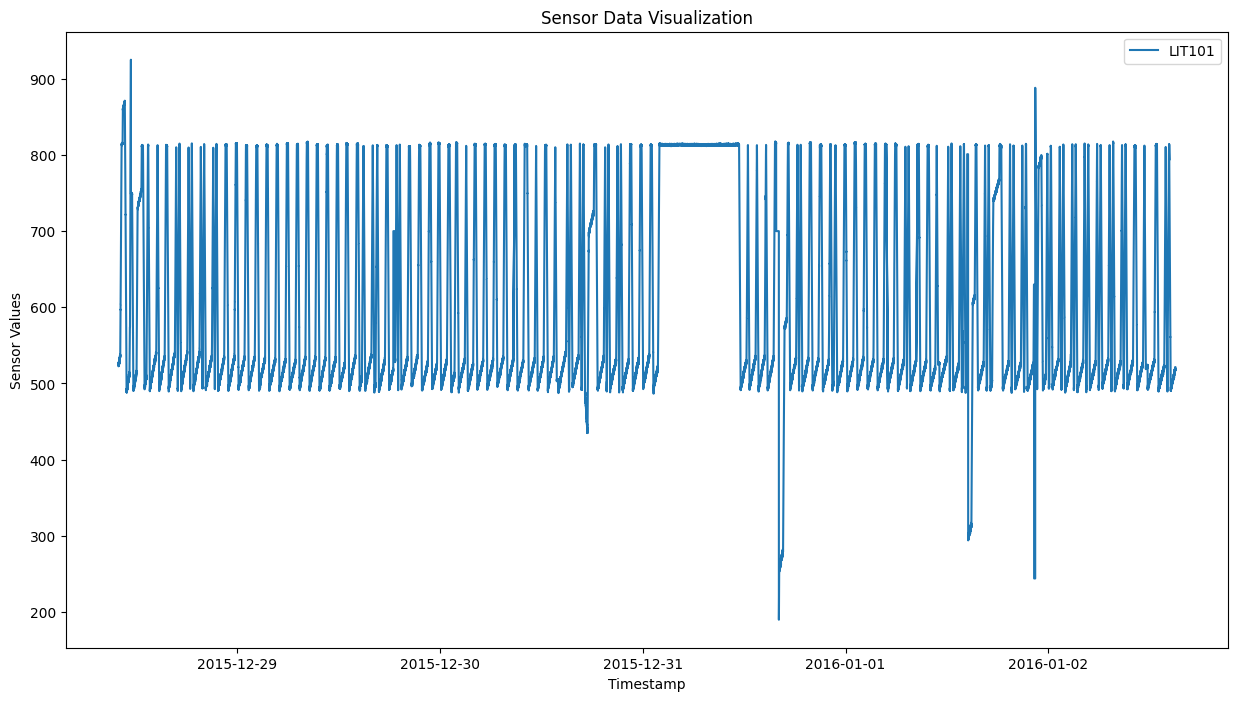

In [343]:
visualize_sensor_data(test_data, sensors=['LIT101'])

Through our own testing and also submitting our results to the kaggle competition, we were able to find that our best result currently makes use of a `threshold equal to 5.7*1e-13`. This provides an accuracy of over `94.5%` when identifying point(also called global) anomalies, as stated by our best submission on kaggle. Below the code, you will be able to see a figure where anomalies identified by our algorithm can be easily differentiated from the normal data.

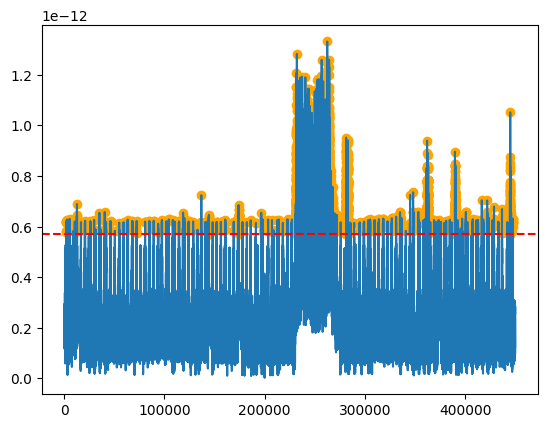

In [344]:
threshold = 57e-14

plt.plot(residuals)
above_threshold_indices = np.where(np.array(residuals) > threshold)[0]
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.scatter(above_threshold_indices, np.array(residuals)[above_threshold_indices], color='orange', label='Above Threshold')